In [1]:
import sys

sys.path.append("../")

import sqlite3
import random


import pandas as pd
import polars as pl

from functions.datamodel import OptimumParameter
from functions.env import DB_SCIENCE_PATH, FULL_DB_PATH, GRAPH_RESULTS
from functions.feat_network import filter_edge_table, get_edge_node_table
from functions.feat_visualization import sygma_graph

pd.options.mode.chained_assignment = None

conn_full_db = sqlite3.connect(FULL_DB_PATH)
conn = sqlite3.connect(DB_SCIENCE_PATH)

optimal_parameters = pd.read_sql("SELECT * FROM optimization", conn)
optimal_parameters = optimal_parameters.sort_values("mean", ascending=False)

dict_op = optimal_parameters.iloc[0].to_dict()
dict_op = OptimumParameter(**dict_op)

columns_to_keep = [
    "re_arabic_world",
    "re_central_europe",
    "re_chinese_world",
    "re_eastern_europe",
    "re_france",
    "re_german_world",
    "re_greek_world",
    "re_indian_world",
    "re_italy",
    "re_japan",
    "re_low_countries",
    "re_nordic_countries",
    "re_persian_world",
    "re_slav_world",
    "re_spain",
    "re_united_kingdom",
]


In [2]:

df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)

df_ind_regions = pd.read_sql_query(
    "SELECT * FROM individuals_regions", conn_full_db
)
df_ind_regions = df_ind_regions.rename(
    columns={"individual_wikidata_id": "wikidata_id"}
)

df_final = pd.merge(df_occupation, df_ind_regions, on="wikidata_id")

df_regions = df_final[["wikidata_id", "region_code"]].drop_duplicates()
df_regions = df_regions[df_regions["region_code"].isin(columns_to_keep)]

df_occupation_min = (
    df_final[["wikidata_id", "meta_occupation"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

random_individuals = []

for occupation in df_occupation_min.meta_occupation.unique():
    # for occupation in list(set(df_occupation_min.meta_occupation)):
    df_select = df_occupation_min[
        df_occupation_min["meta_occupation"] == occupation
    ]

    my_list = df_select.wikidata_id.unique()
    my_list = list(df_select.wikidata_id)

    if len(my_list) <= 20:
        selected_elements = my_list
    else:
        selected_elements = pd.DataFrame(my_list)
        selected_elements = list(
            pd.DataFrame(selected_elements).sample(20, random_state=42)[0].values
        )

    # selected_elements = random.sample(my_list, 20)

    random_individuals.append(selected_elements)

random_individuals = [item for sublist in random_individuals for item in sublist]

final = []

for region in columns_to_keep:
    df_sample = df_regions[df_regions["region_code"] == region]

    if len(df_sample) > 100:
        res = df_sample.sample(100, random_state=42)
    else:
        res = df_sample.copy()

    final.append(res)

df_fin = pd.concat([x for x in final])

individuals_filters = list(df_fin["wikidata_id"])
final_individuals = individuals_filters + random_individuals
final_individuals = pd.DataFrame(final_individuals).drop_duplicates()
final_individuals = list(final_individuals[0].values)

df = df_occupation[df_occupation["wikidata_id"].isin(final_individuals)]
df.columns = ["source", "target"]
df["weight"] = 1

df = pl.from_pandas(df)
df_edge, df_nodes = get_edge_node_table(df)

df_edge_filter = filter_edge_table(
    df_edge,
    edge_rule=dict_op.edge_rule,
    top_directed_neighbours=dict_op.n_neighbours,
    normalize_on_top=False,
    min_count_link=0,
)

df_partition, g = sygma_graph(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    resolution=dict_op.resolution,
    filepath=GRAPH_RESULTS + "/100.html",
)

df_partition.to_sql(
    "optimal_partition_weighted", conn, if_exists="replace", index=False
)


28

In [20]:
#The node degree is the number of edges adjacent to the node. 
#The weighted node degree is the sum of the edge weights for edges incident to that node.

df_degree = pd.DataFrame(g.degree(), columns = ['occupation', 'degree'])
df_degree = df_degree.sort_values('degree', ascending=False)
df_degree

,occupation,degree
1,botanist,22
10,philosopher,19
18,historian,18
12,mathematician,16
7,geographer,15
15,physicist,15
19,anthropologist,14
13,astronomer,12
4,anatomist,12
0,zoologist,12


In [47]:
import community.community_louvain as community

# Detect communities using Louvain algorithm
partition = community.best_partition(g)

# Get a set of the communities
communities = set(partition.values())

# Create a dictionary mapping community number to nodes within that community
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}

In [63]:
centrality = nx.group_betweenness_centrality(g, list(communities_dict.values()))

In [ ]:
list(communities_dict.values())

In [97]:
df_centrality=pd.DataFrame(nx.degree_centrality(g), index = [0]).T.reset_index()
df_centrality.columns = ['occupation', 'centrality']

df_all = pd.DataFrame(g.nodes(data=True))
df_all['node_size'] = df_all[1].apply(lambda x: x.get('node_size'))
df_all = df_all.rename(columns = {0:'occupation'})
df_all = df_all.drop(1, axis=1)
df = pd.merge(df_centrality, df_all, on = 'occupation')


# Min-Max scaling to normalize columns between 0 and 1
df['centrality'] = (df['centrality'] - df['centrality'].min()) / (df['centrality'].max() - df['centrality'].min())
df['node_size'] = (df['node_size'] - df['node_size'].min()) / (df['node_size'].max() - df['node_size'].min())

In [98]:
import matplotlib.pyplot as plt


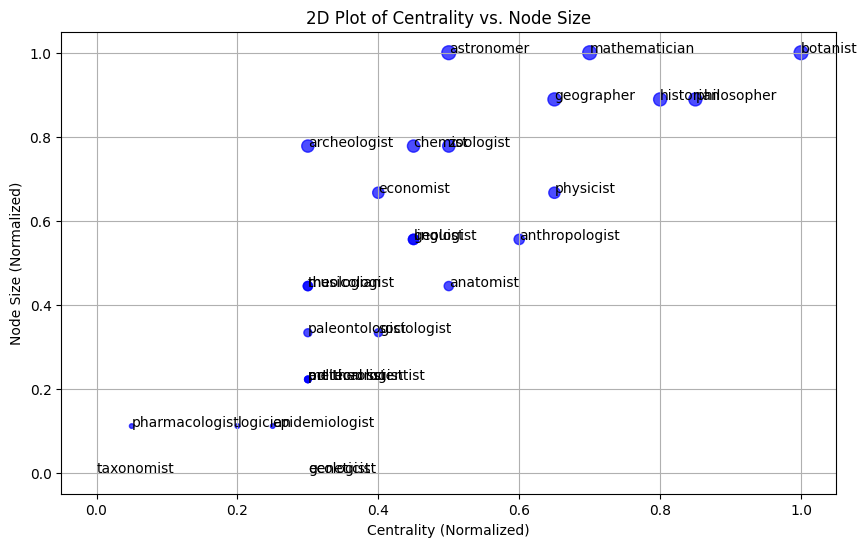

In [99]:
# Create a 2D plot
plt.figure(figsize=(10, 6))
plt.scatter(df['centrality'], df['node_size'], s=df['node_size']*100, c='b', alpha=0.7)

# Label the points with the occupation names
for i, txt in enumerate(df['occupation']):
    plt.annotate(txt, (df['centrality'][i], df['node_size'][i]), fontsize=10)

# Set axis labels and title
plt.xlabel('Centrality (Normalized)')
plt.ylabel('Node Size (Normalized)')
plt.title('2D Plot of Centrality vs. Node Size')

# Show the plot
plt.grid()
plt.show()